# Use CNN to detect if an image has a horse or a human

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import subprocess
import zipfile
import random
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Load and explore data

In [2]:
## Create a folder to download our data
data_folder = 'data'
if not os.path.exists(data_folder):
    print("Creating data folder...")
    os.mkdir(data_folder)
    
## Download data
download_command = '''wget \
--no-check-certificate \
https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
-O data/horse-or-human.zip'''

if not os.path.exists(data_folder + '/horse-or-human.zip'):
    print("Downloading data...")
    os.system(download_command)
    
## Download data
download_command_val = '''wget \
--no-check-certificate \
https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
-O data/validation-horse-or-human.zip'''

if not os.path.exists(data_folder + '/horse-or-human.zip'):
    print("Downloading data...")
    os.system(download_command)
    
if not os.path.exists(data_folder + '/validation-horse-or-human.zip'):
    print("Downloading validation data...")
    os.system(download_command_val)

In [3]:
## Unzip
zip_ref = zipfile.ZipFile(data_folder + '/horse-or-human.zip','r')
zip_ref.extractall('data/horse-or-human')
zip_ref.close()

## Unzip
zip_ref_val = zipfile.ZipFile(data_folder + '/validation-horse-or-human.zip','r')
zip_ref_val.extractall('data/validation-horse-or-human')
zip_ref_val.close()

Sub-folders labeled `humans` and `horses` have been created. This will be useful later on when using `ImageGenerator`

In [4]:
train_horse_dir = os.path.join(data_folder + '/horse-or-human/horses')
train_human_dir = os.path.join(data_folder + '/horse-or-human/humans')

train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:3])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:3])

print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

val_horse_dir = os.path.join(data_folder + '/validation-horse-or-human/horses')
val_human_dir = os.path.join(data_folder + '/validation-horse-or-human/humans')

val_horse_names = os.listdir(val_horse_dir)
print(val_horse_names[:3])

val_human_names = os.listdir(val_human_dir)
print(val_human_names[:3])

print('total validation horse images:', len(os.listdir(val_horse_dir)))
print('total validation human images:', len(os.listdir(val_human_dir)))

['horse42-5.png', 'horse42-1.png', 'horse47-2.png']
['human09-27.png', 'human02-30.png', 'human11-14.png']
total training horse images: 500
total training human images: 527
['horse5-342.png', 'horse4-403.png', 'horse6-544.png']
['valhuman02-03.png', 'valhuman05-22.png', 'valhuman04-11.png']
total validation horse images: 128
total validation human images: 128


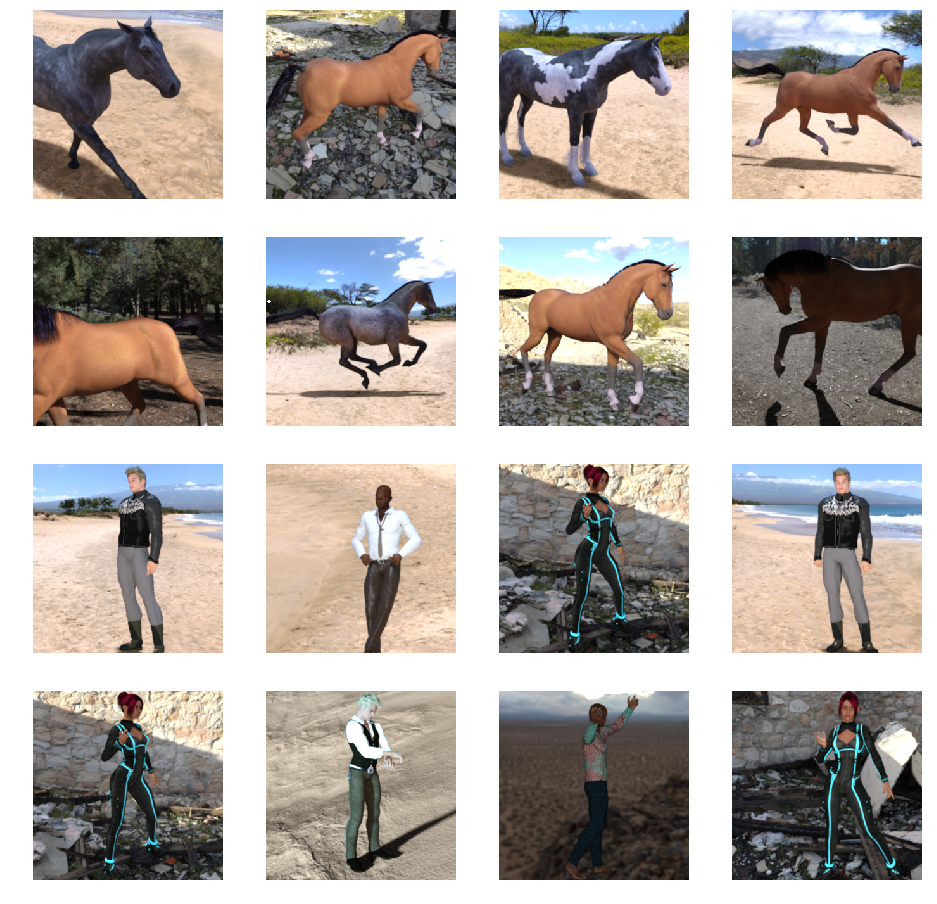

In [5]:
nrows = 4
ncols = 4
pic_index = 50

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows *4)

pic_index +=8
next_horse_pix = [os.path.join(train_horse_dir, fname)
                  for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname)
                  for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
    sp = plt.subplot(nrows, ncols, i+1)
    sp.axis('Off')
    
    img = mpimg.imread(img_path)
    plt.imshow(img)
    
plt.show()

## Build the CNN
5 CNNs and a NN at the end

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300,300,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    ## Flatten
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

model.summary()

W0705 10:03:16.117553 140316324833088 deprecation.py:506] From /home/elder/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

In [7]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

W0705 10:03:16.269331 140316324833088 deprecation.py:323] From /home/elder/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Data Preprocessing
The data generator will read pictures directly from the source folders, convert them to tensors, and feed them with labels to our NN.

In [8]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

# Pass training images in batches of 128
train_generator = train_datagen.flow_from_directory('data/horse-or-human/',
                                                   target_size=(300,300),
                                                   batch_size=128,
                                                   class_mode='binary')

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

# Pass training images in batches of 128
validation_generator = validation_datagen.flow_from_directory('data/validation-horse-or-human/',
                                                              target_size=(300,300),
                                                              batch_size=128,
                                                              class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


## Training

In [9]:
class myCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.9999:
            print("\nReached 99.99% accuracy, interrupting training!")
            self.model.stop_training = True
            
callbacks = myCallback()

history = model.fit_generator(train_generator,
                              steps_per_epoch=8,
                              epochs=100,
                              callbacks=[callbacks],
                              verbose=1,
                              validation_data = validation_generator,
                              validation_steps=8
                             )

Epoch 1/100
8/8 [==============================] - 10s 1s/step - loss: 0.8670 - acc: 0.5028 - val_loss: 0.5805 - val_acc: 0.6289
Epoch 2/100
8/8 [==============================] - 9s 1s/step - loss: 1.0483 - acc: 0.6218 - val_loss: 0.5118 - val_acc: 0.7344
Epoch 3/100
8/8 [==============================] - 10s 1s/step - loss: 0.5361 - acc: 0.8443 - val_loss: 0.4462 - val_acc: 0.8672
Epoch 4/100
8/8 [==============================] - 10s 1s/step - loss: 0.2684 - acc: 0.8877 - val_loss: 0.3822 - val_acc: 0.9023
Epoch 5/100
8/8 [==============================] - 10s 1s/step - loss: 0.3052 - acc: 0.8695 - val_loss: 0.7151 - val_acc: 0.8359
Epoch 6/100
8/8 [==============================] - 10s 1s/step - loss: 0.0873 - acc: 0.9700 - val_loss: 1.0627 - val_acc: 0.8555
Epoch 7/100
8/8 [==============================] - 11s 1s/step - loss: 0.1575 - acc: 0.9355 - val_loss: 1.6294 - val_acc: 0.8047
Epoch 8/100
8/8 [==============================] - 10s 1s/step - loss: 0.5247 - acc: 0.9299 - val_

## Test the model

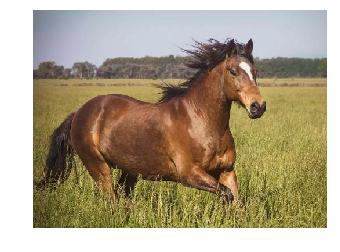

(300, 300, 3)
(1, 300, 300, 3)
[[0.]]
data/horse.jpg is a horse


In [10]:
img_path = 'data/horse.jpg'

img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

img_horse = tf.keras.preprocessing.image.load_img(img_path, target_size=(300,300))
x = tf.keras.preprocessing.image.img_to_array(img_horse)
print(x.shape)
x = np.expand_dims(x, axis=0)
print(x.shape)
## This is if we had multiple images
images = np.vstack([x])

## Run the model
classes = model.predict(images,batch_size=10)
print(classes)

if classes[0]>0.5:
    print(img_path + " is a human")
else:
    print(img_path + " is a horse")

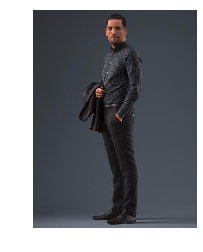

(300, 300, 3)
(1, 300, 300, 3)
[[1.]]
data/human.jpg is a human


In [11]:
img_path = 'data/human.jpg'

img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

img_horse = tf.keras.preprocessing.image.load_img(img_path, target_size=(300,300))
x = tf.keras.preprocessing.image.img_to_array(img_horse)
print(x.shape)
x = np.expand_dims(x, axis=0)
print(x.shape)
## This is if we had multiple images
images = np.vstack([x])

## Run the model
classes = model.predict(images,batch_size=10)
print(classes)

if classes[0]>0.5:
    print(img_path + " is a human")
else:
    print(img_path + " is a horse")

## Visualize Intermediate Represnatation
Let's look at how the input image is transformed as it goes through the convolutional NN.

Each row corresponds to the output of a layer, and each image in the row is a specific convolution in the output feature map.

In [12]:
## Let's define a model that will take an image as input, and will
## output intermediate representations
succesive_outputs = [layer.output for layer in model.layers]

visualization_model = tf.keras.models.Model(inputs = model.input,
                                            outputs = succesive_outputs)

## Let's grab a random input image
horse_image_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_image_files = [os.path.join(train_human_dir, f) for f in train_human_names]

def DrawIntermediateRepresentation():

    random_img = random.choice(horse_image_files+human_image_files)

    img = tf.keras.preprocessing.image.load_img(random_img, target_size=(300,300))
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    ## Rescale
    x /= 255.

    sucessive_feature_maps = visualization_model.predict(x)

    ## Get layer names before we loop them
    layer_names = [layer.name for layer in model.layers]

    ## And now loop
    for layer_name, feature_map in zip(layer_names, sucessive_feature_maps):
    
        ## Only deal with conv and maxpooling layers
        ## not fully connected layers
        ## The feature map has shape (1, size, size, n_features)
        if len(feature_map.shape) == 4:
            n_features = feature_map.shape[-1]
            size = feature_map.shape[1]
            display_grid = np.zeros((size, size*n_features))
        
            for i in range(n_features):
                ## Get the image
                x = feature_map[0,:,:,i]
                ## Do some postprocessing
                x -= x.mean()
                x /= x.std()
                x *=64
                x += 128
                x = np.clip(x, 0, 255).astype('uint8')
            
                ## And then each conv goes into the grid
                display_grid[:,i*size:(i+1)*size] = x
        
            ## Display the grid
            scale = 20./n_features
            plt.figure(figsize=(scale*n_features, scale))
            title_name = layer_name,'has',n_features,'features'
            plt.title(title_name)
            plt.grid(False)
            plt.imshow(display_grid, aspect='auto', cmap='viridis')

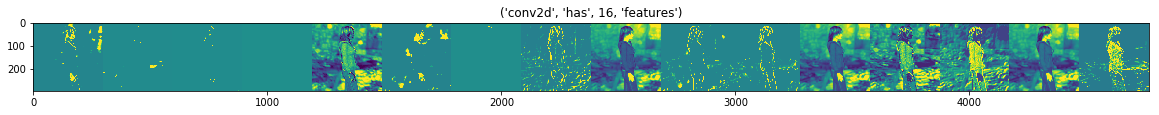

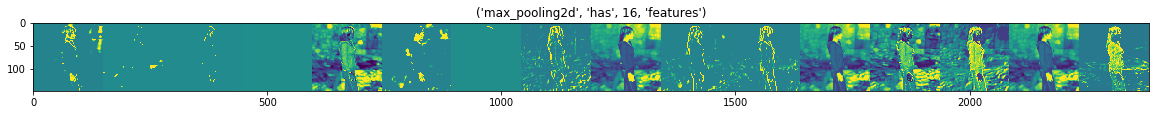

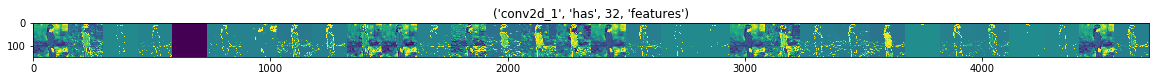

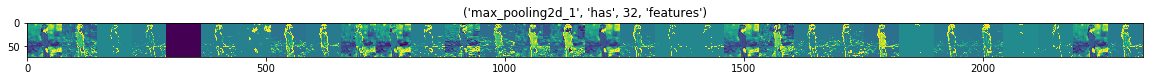

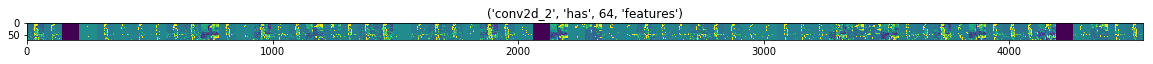

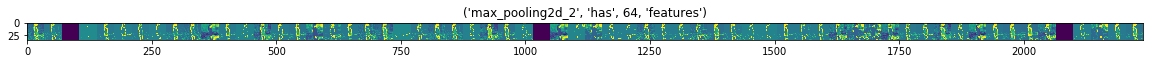

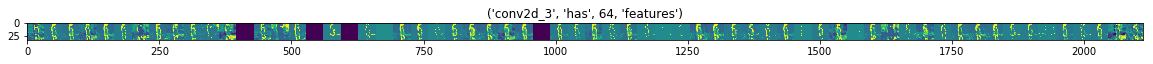

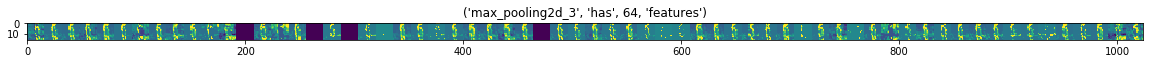

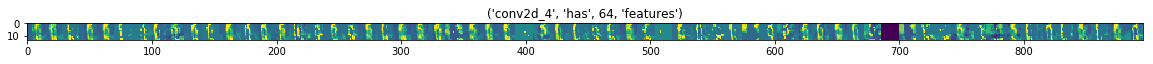

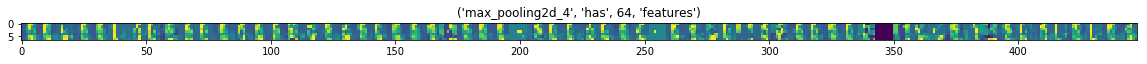

In [13]:
DrawIntermediateRepresentation()

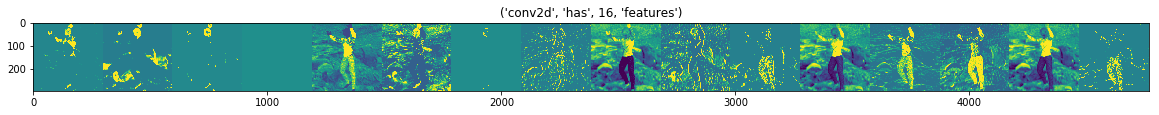

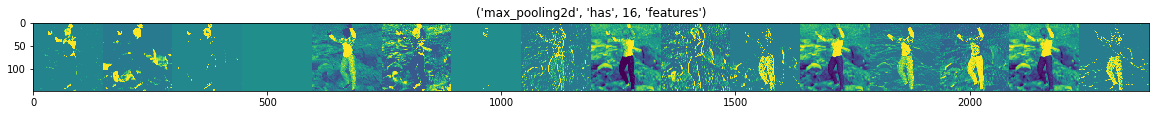

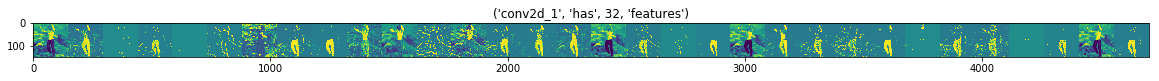

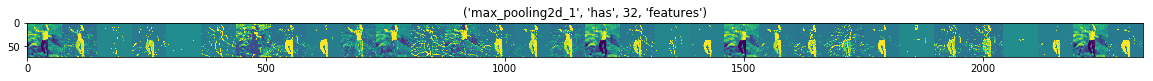

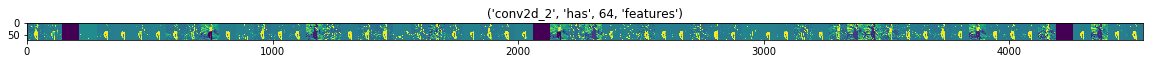

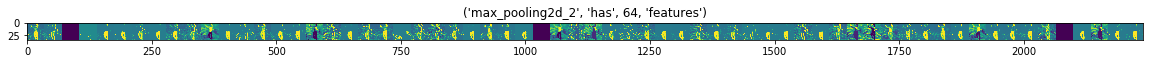

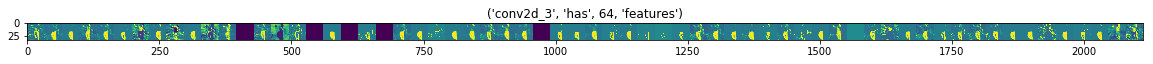

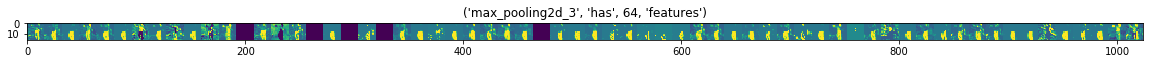

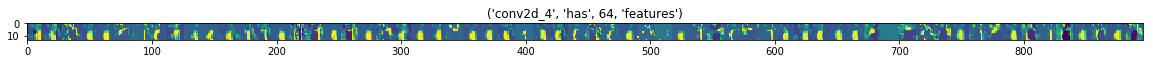

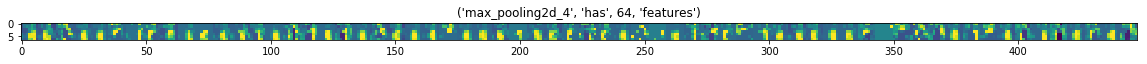

In [14]:
DrawIntermediateRepresentation()

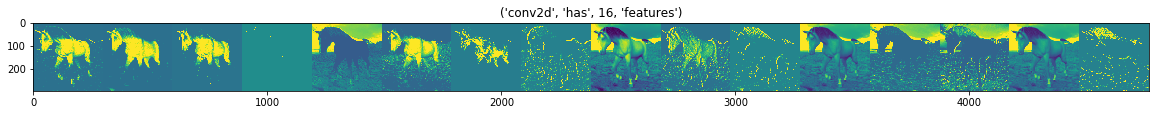

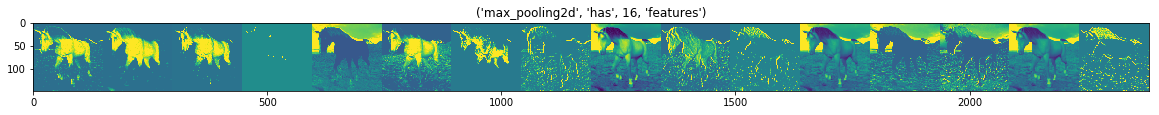

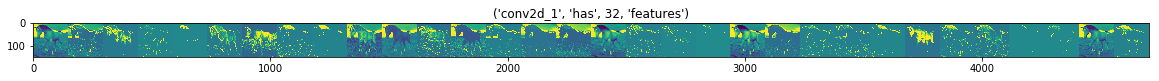

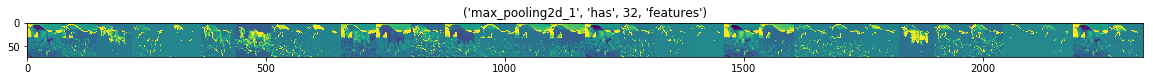

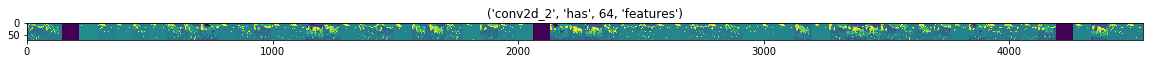

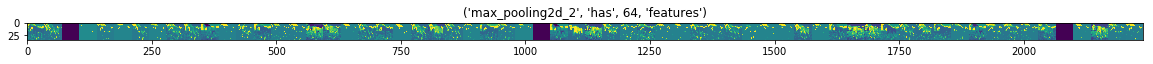

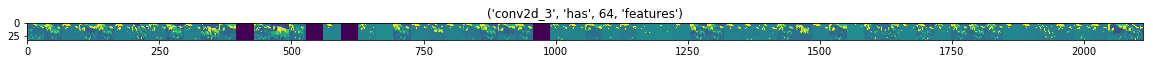

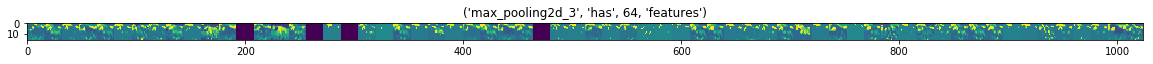

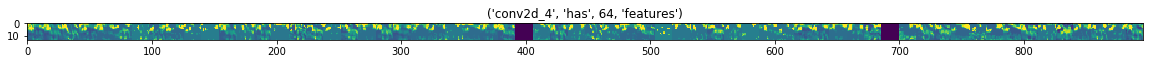

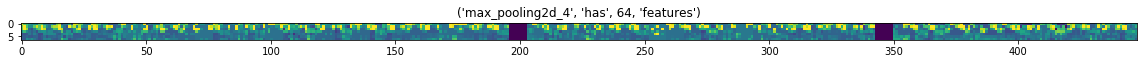

In [15]:
DrawIntermediateRepresentation()

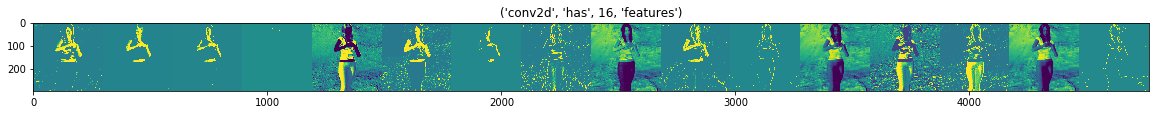

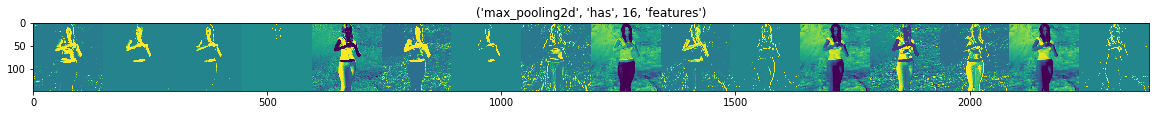

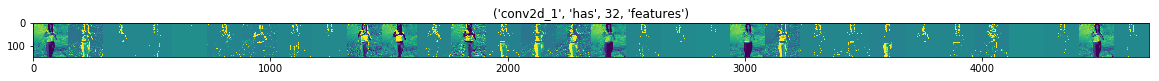

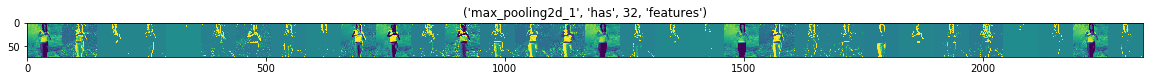

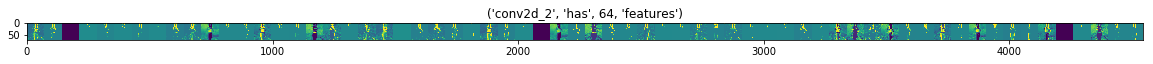

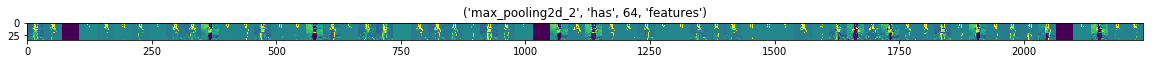

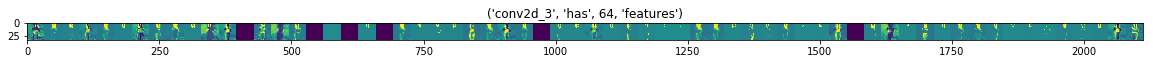

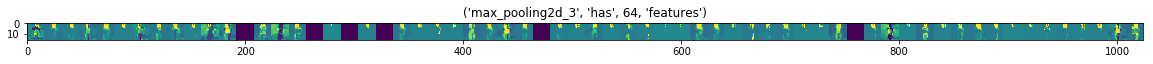

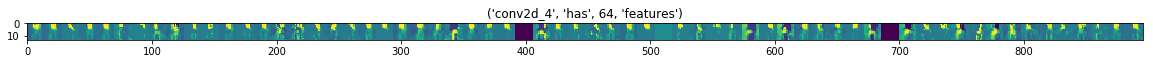

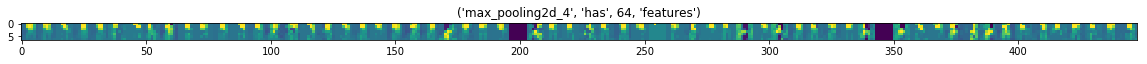

In [16]:
DrawIntermediateRepresentation()

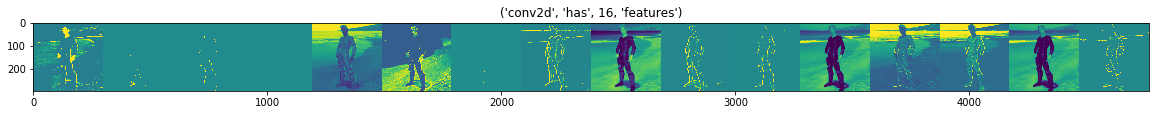

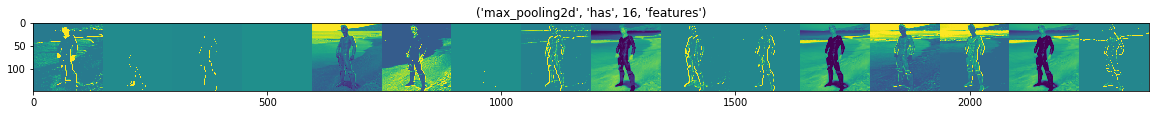

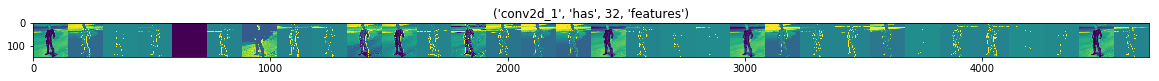

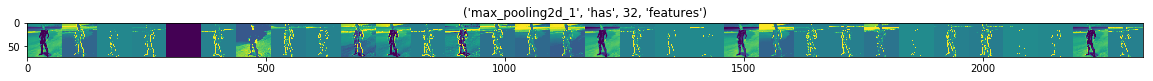

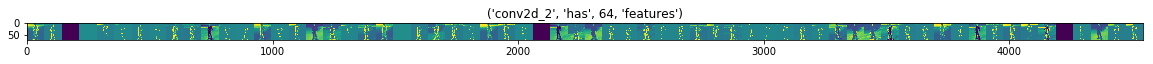

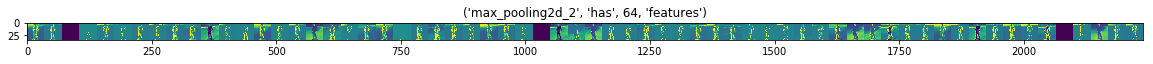

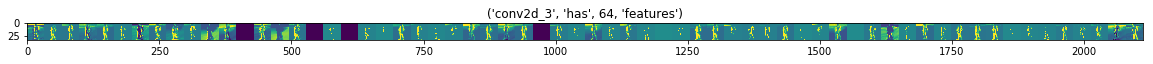

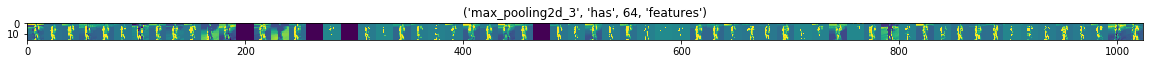

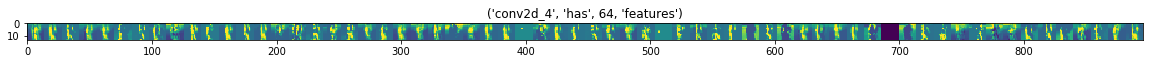

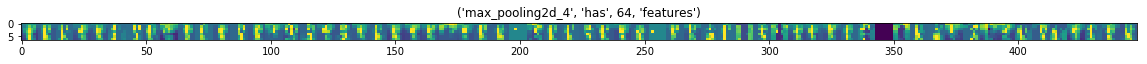

In [17]:
DrawIntermediateRepresentation()